In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from obspy.geodetics import calc_vincenty_inverse
from obspy.geodetics import locations2degrees
import obspy
from obspy.taup import TauPyModel
import numpy as np

# For plot style can be ignored
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("talk")

import pyadjoint
from pyadjoint.config import ConfigCrossCorrelation

import glob
import os

# Computing attenuation kernel

Assuming that $Q^{-1}$ is
constant over the seismic frequency band, the frequency-dependent
shear modulus may be written as (Liu et al, 1976).

$$
\mu(\omega) = \mu(\omega_0)[1 + (2/\pi)Q^{-1}_{\mu}ln(|\omega|/\omega_0) - isgn(\omega)Q^{-1}_{\mu}]
$$

where $\omega_0$ is the reference frequency. Gradient of the shear modulus due to perturbations in shear attunueation is:

$$
\delta \mu(\omega) =
\mu(\omega_0)[(2/\pi)ln(|\omega|/\omega_0) -isgn(\omega)] \delta Q^{-1}_{\mu}
$$

where the $(2/\pi)ln(|\omega|/\omega_0)$ captures the physical dispersion
around the reference frequency.

Gradient of the misfit function can be defined in terms of perturbations in anelastic structure.

$$
\delta \chi = \int_V K_{\mu}^{Q}(\mathbf{x}) \delta Q^{-1}_{\mu}(\mathbf{x}) d^3\mathbf{x}
$$

where the $Q_\kappa$ is ignored since the intrinsic attenuation is
dominated by shear attenuation $Q_\mu^{-1}$.  Using Born approximation, we may
define the anelastic adjoint source as:


$$
\tilde{f}^{\dagger}_i (\mathbf{x}, t)
= \frac{1}{2\pi} \int_{-\infty}^{\infty}
[(2/\pi)ln(|\omega|/\omega_0) -isgn(\omega)]^*
f^{\dagger}_i (\mathbf{x}, \omega) \exp{(i\omega t)} d\omega,
$$

where $f^{\dagger}_i$ is the elastic adjoint source (forward in time).

Using the anelastic adjoint source, $K_\mu$ acts as the attenuation kernel $K_{\mu}^{Q}$.

# Python tools

Both elastic and anelastic adjoint source can be computed using `pyadjoint` package.

First install `obspy`:

    pip install obspy
    
Then clone and install the anelastic branch of the `pyadjoint` package:

    git clone --branch anelastic_devel https://github.com/rdno/pyadjoint.git
    python setup.py develop
 

# Functions

In [2]:
def get_ylim(ax, tr, offset=0.0, padding=1.0):
    xlim = ax.get_xlim()
    left = np.abs(tr.times()-xlim[0]+offset).argmin()
    right = np.abs(tr.times()-xlim[1]+offset).argmin()
    top = np.max(tr.data[left:right])
    bot = np.min(tr.data[left:right])
    top = (1.0+padding)*top if top > 0 else (1.0-padding)*top
    bot = (1.0+padding)*bot if bot < 0 else (1.0-padding)*bot
    return bot, top

# Data 

In [3]:
# Read event data
cat = obspy.read_events("CMTSOLUTION", format="CMTSOLUTION")
event = cat[0]
halfdur = event.focal_mechanisms[0].moment_tensor.source_time_function.duration / 2
offset = -1.5*halfdur  # origin time offset
origin = event.preferred_origin()
event_lat = origin.latitude
event_lon = origin.longitude

In [4]:
# Read station data
with open("STATIONS") as f:
    for line in f:
        sta, net, sta_lat, sta_lon, _, _ = line.split()
        sta_lat = float(sta_lat)
        sta_lon = float(sta_lon)
        break

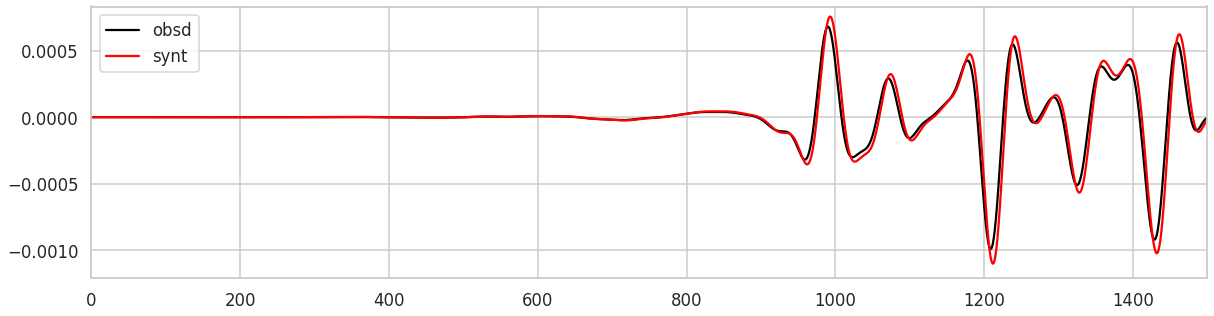

In [5]:
# Read synthetic data
synts = obspy.read("seis/AA.A0001.MX*.sem.sac")
# Calculate distance, azimuth, backazimuth
dist_m, az, baz = calc_vincenty_inverse(event_lat, event_lon, sta_lat, sta_lon)
# Rotate seismograms
synts.rotate("NE->RT", back_azimuth=baz)
# Select transverse component and bandpass filter 40-250 s
synt = synts.select(channel="*T")[0]
synt.filter("bandpass", freqmin=1.0/250, freqmax=1.0/40, zerophase=True)
# Copy synt trace to get "observed" data
obsd = synt.copy()
# "observed" data is shifted by 3 seconds and have 0.9 amplitude of the synt
shift = int(round(3.0/synt.stats.delta))
obsd.data[:-shift] = obsd.data[shift:]
obsd.data[-shift:] = 0
obsd.data *= 0.9

# Plot the data
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(obsd.times()+offset, obsd.data, "k", label="obsd")
ax.plot(synt.times()+offset, synt.data, "r", label="synt")
ax.legend()
ax.set_xlim([0, 1500])
ax.set_ylim(get_ylim(ax, synt, offset=offset, padding=0.1));

# Adjoint Sources


In [6]:
# S-wave window
windows = np.array([[950, 1030]])-offset

### Elastic Adjoint Source
Cross-correlation elastic adjoint source is computed using following equation:
$$
    f^{\dagger}(t) = - \left[ T^{obs} - T(\mathbf{m}) \right] ~ \frac{1}{N} ~
    \partial_t \mathbf{s}(T - t, \mathbf{m})
$$

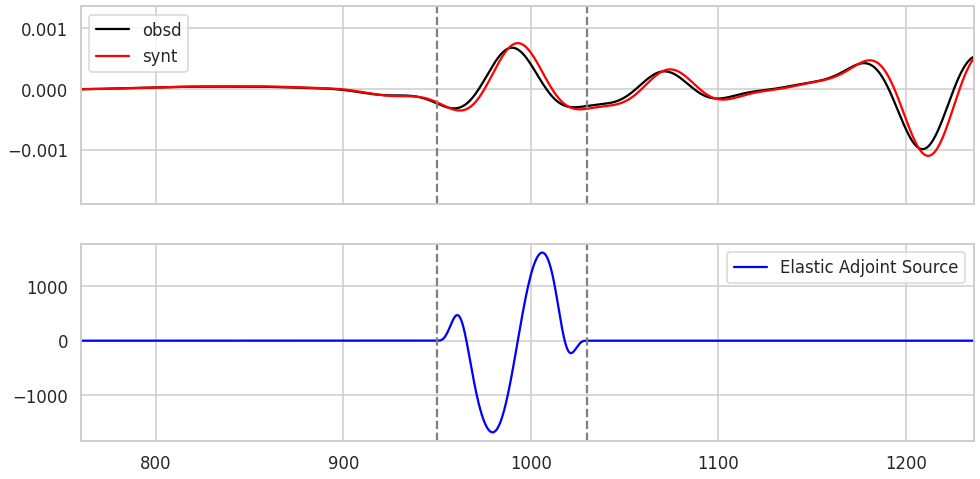

In [7]:
# Define the adjoint source config
cc_config = ConfigCrossCorrelation(40.0, 250.0, taper_type="cos_p10", taper_percentage=1.0, measure_type="dt")

# Calculate the adjoint source
elastic_adj = pyadjoint.calculate_adjoint_source("cc_traveltime_misfit",
                                                 obsd, synt, cc_config,
                                                 windows)

times = synt.times() + offset
win_offset = windows + offset

fig, axes = plt.subplots(figsize=(16, 8), nrows=2, sharex=True)
axes[0].plot(times, obsd.data, "k", label="obsd")
axes[0].plot(times, synt.data, "r", label="synt")
axes[0].set_xlim((win_offset[0][0]*0.8, win_offset[0][1]*1.2))
axes[0].axvline(win_offset[0][0], color="gray", linestyle="--")
axes[0].axvline(win_offset[0][1], color="gray", linestyle="--")
axes[0].set_ylim(get_ylim(axes[0], obsd))
axes[0].legend()

axes[1].plot(times, elastic_adj.adjoint_source[::-1], "b", label="Elastic Adjoint Source")
axes[1].axvline(win_offset[0][0], color="gray", linestyle="--")
axes[1].axvline(win_offset[0][1], color="gray", linestyle="--")
axes[1].legend()

# Anelastic Adjoint Source
First cross-correlation traveltime adjoint is computed than the following equation attenuation adjoint source is computed.

$$
\tilde{f}^{\dagger}_i (\mathbf{x}, t)
= \frac{1}{2\pi} \int_{-\infty}^{\infty}
[(2/\pi)ln(|\omega|/\omega_0) -isgn(\omega)]^*
f^{\dagger}_i (\mathbf{x}, \omega) \exp{(i\omega t)} d\omega,
$$

where $f^{\dagger}_i$ is the elastic adjoint source (forward in time).


In [8]:
# Read from SPECFEM
min_period = 30
max_period = 1733

ref_period = 10**(0.5 * (np.log10(min_period) + np.log10(max_period)))
print("ref_period:", ref_period)
ref_freq = 1.0/ref_period

ref_period: 228.013157515


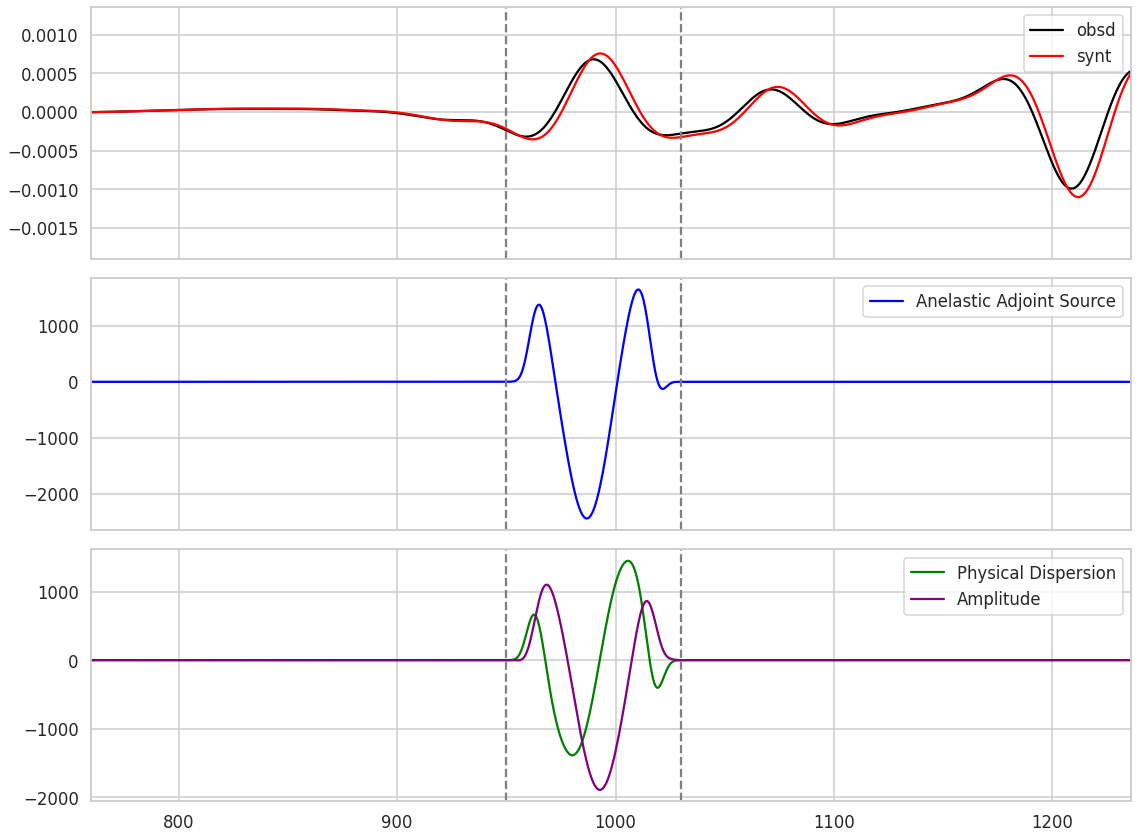

In [9]:
# Define the adjoint source config
cc_config = ConfigCrossCorrelation(40.0, 250.0, taper_type="cos_p10", taper_percentage=1.0, measure_type="dt")

# Calculate the adjoint source
anelastic_adj = pyadjoint.calculate_attenuation_adjoint_source("cc_traveltime_misfit",
                                                             obsd, synt, cc_config,
                                                             windows,
                                                             f0=ref_freq)

times = synt.times() + offset
win_offset = windows + offset

fig, axes = plt.subplots(figsize=(16, 12), nrows=3, sharex=True)
axes[0].plot(times, obsd.data, "k", label="obsd")
axes[0].plot(times, synt.data, "r", label="synt")
axes[0].set_xlim((win_offset[0][0]*0.8, win_offset[0][1]*1.2))
axes[0].axvline(win_offset[0][0], color="gray", linestyle="--")
axes[0].axvline(win_offset[0][1], color="gray", linestyle="--")
axes[0].set_ylim(get_ylim(axes[0], obsd))
axes[0].legend()

axes[1].plot(times, anelastic_adj.adjoint_source[::-1], "b", label="Anelastic Adjoint Source")
axes[1].axvline(win_offset[0][0], color="gray", linestyle="--")
axes[1].axvline(win_offset[0][1], color="gray", linestyle="--")
axes[1].legend()

# axes[2].plot(times, anelastic_adj.adjoint_source[::-1], "b", label="Attenuation Adjoint Source")
axes[2].plot(times, anelastic_adj.adjoint_source_1[::-1], "green", label="Physical Dispersion")
axes[2].plot(times, anelastic_adj.adjoint_source_2[::-1], "purple", label="Amplitude")
axes[2].legend()
axes[2].axvline(win_offset[0][0], color="gray", linestyle="--")
axes[2].axvline(win_offset[0][1], color="gray", linestyle="--")
plt.tight_layout()

## Kernels

### Elastic Kernel
![Elastic Kernel](./kernels/dt_228_elastic.png "Elastic Kernel")

### Anelastic Kernel
![Anelastic Kernel](./kernels/dt_228_anelastic.png "Anelastic Kernel")